In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from numba import njit
import time

In [3]:
!pip install --upgrade quantecon
#import quantecon as qe
from quantecon import markov, MarkovChain
from math import erfc, sqrt

Requirement already up-to-date: quantecon in c:\users\woute\anaconda3\lib\site-packages (0.4.5)


**EXERCISE 2 - SETUP**

In [4]:
θ = 0.21
ν = 0.64
δ = 0.1
β = 0.96
ϕ = 0.5

In [5]:
ρ = 0.9   ## SETTING UP THE MARKOV PROBAILITIES AND STATES FOR WHAT FOLLOWS
σ = 0.02

MC = markov.approximation.tauchen(ρ, σ, n=10).P
print("The matrix of transition probabilities is:", MC)
x = markov.approximation.tauchen(ρ, σ, n=10).state_values
print("The states are:", x)

The matrix of transition probabilities is: [[5.30478170e-01 4.15375002e-01 5.32885772e-02 8.56706028e-04
  1.54439460e-06 2.92857183e-10 5.66213743e-15 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.67966302e-02 4.93930466e-01 3.69971746e-01 3.87971726e-02
  5.03259844e-04 7.25892202e-07 1.09655174e-10 1.66533454e-15
  0.00000000e+00 0.00000000e+00]
 [3.71959075e-03 1.21954964e-01 5.23228103e-01 3.23146274e-01
  2.76615366e-02 2.89198006e-04 3.33562232e-07 4.01295663e-11
  4.44089210e-16 0.00000000e+00]
 [2.52812798e-05 5.78316444e-03 1.54270165e-01 5.43701344e-01
  2.76746317e-01 1.93110204e-02 1.62557651e-04 1.49849563e-07
  1.43532963e-11 1.11022302e-16]
 [2.82551739e-08 4.80546862e-05 8.83083400e-03 1.91241547e-01
  5.54230974e-01 2.32360418e-01 1.31987073e-02 8.93711456e-05
  6.58100220e-08 5.01743092e-12]
 [5.01748193e-12 6.58100220e-08 8.93711456e-05 1.31987073e-02
  2.32360418e-01 5.54230974e-01 1.91241547e-01 8.83083400e-03
  4.80546862e-05 2.82551739e-08]
 [1.39013711e-1

In [6]:
#compute the stationary distribution corresponding to our Markov chain
x_stat = np.ones(10)*0.1 #set an initial distribution
#x_stat = [0.05,0.05,0.05,0.05,0.1,0.1,0.1,0.25,0.25,0]

t = 1000 # path length
x_vals = np.zeros((t,len(x_stat)))

for ii in range(t):            
    for jj in range(len(x)):
        x_vals[ii,jj] = x_stat[jj]

    x_stat = np.dot(x_stat,MC) # update distribution

#print(x_vals[-5:-1,:])       
print(x_stat)
print("the sum is:", np.sum(x_stat[:]))

[0.00575924 0.02496288 0.07627247 0.16041558 0.23258983 0.23258983
 0.16041558 0.07627247 0.02496288 0.00575924]
the sum is: 1.0000000000000042


**EXERCISE 2 - SOLUTION OF THE STEADY STATE**

In [7]:
def steady(params, n_bar):
    θ, ν, δ, β, ϕ = params
    
    r_bar = 1/β - (1-δ)
    k_bar = (r_bar/(θ*(n_bar)**ν))**(1/(θ-1)) #( (0.5*ϕ*(-δ)**2 - ϕ*δ - (1-δ)) / (n_bar**ν) )**(1/(θ-1))
    y_bar = k_bar**θ * n_bar**ν
    i_bar = δ * k_bar
    w_bar = ν * k_bar**θ * n_bar**(ν-1)
    c_bar = k_bar**θ * n_bar**ν - i_bar ## - w_bar*n_bar - k_bar*0.5*ϕ*(-δ)**2
    a_bar = (w_bar*n_bar)/c_bar
    
    return r_bar, k_bar, y_bar, i_bar, w_bar, c_bar, a_bar

In [8]:
params = θ, ν, δ, β, ϕ
print(steady(params, 0.6))

(0.14166666666666672, 1.0881001887382777, 0.7340358416091558, 0.10881001887382778, 0.7829715643830996, 0.625225822735328, 0.7513812154696132)


**EXERCISE 3 - VFI**

In [9]:
params = θ, ν, δ, β, ϕ
w_rep = steady(params, 0.6)[4] #0.7829715643830996
#print(w_rep)
c_f = 0.01

In [10]:
@njit
def V1_fun(k, kp, ee, w_rep, V_guess, params):
    
    θ, ν, δ, β, ϕ = params
    
    state = x[ee]
    E = np.exp(state)
    n = (w_rep/(ν*E*(k**θ)))**(1/(ν-1))
    
    EV = np.dot(V_guess[:],MC[ee,:])
    
    V1 = E*(k**(θ))*(n**(ν)) - w_rep*n - (kp - (1-δ)*k) - k*(ϕ/2)*(kp/k - (1-δ))**2 + β * EV
    
    return V1

In [20]:
@njit
def solve_incum(w, params, nk, k_grid):
    #start_time = time.clock()
    
    eps = 0.0001
    max_iter = 1000
    
    crit = 1
    itr = 0
    
    θ, ν, δ, β, ϕ = params
    
    V = np.zeros((nk,10))
    MV = np.zeros((nk,10))
    pol = np.zeros_like(V)
    
    while crit > eps and itr < max_iter:
        #print('Iteration: {}'.format(itr + 1))

        V_new = np.zeros_like(V)

        for ii in range(nk): #loop over k grid (now)
            k = k_grid[ii]
            for ee in range(10):
                max_V = -9999999999999
                idx = 0

                for jj in range(nk): 

                    maxim_val = V1_fun(k, k_grid[jj], ee, w_rep, V[jj,:], params)
                    if (1-δ)*k > maxim_val-c_f:
                        if max_V < (1-δ)*k:
                            max_V = (1-δ)*k
                            idx = -2
                    else:
                        if max_V < maxim_val - c_f:
                            max_V = maxim_val - c_f
                            idx = jj

                V_new[ii,ee] = max_V
                if idx > -2:
                    pol[ii,ee] = k_grid[int(idx)]
                else:
                    pol[ii,ee] = -2

        V_new[0,:] = 0
        crit = np.max(np.abs(V - V_new))

        V = V_new.copy()
        itr += 1

    #ss_time = time.clock() - start_time
    print("the V difference is:", crit)
    #print("time elapsed:", ss_time)
    #print(V)
    
    return V, pol

In [21]:
nk = 50
k_low = 0.01 
k_high = 2
k_grid = np.linspace(k_low, k_high, nk)

V, pol = solve_incum(w_rep, params, nk, k_grid)

the V difference is: 9.899960677373087e-05


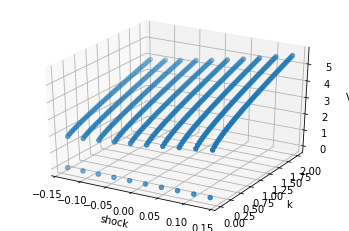

In [22]:
## plot the Value function V(k,ϵ)
x_grid = np.linspace(x[0], x[9], 10)
y_grid = np.linspace(k_low, k_high, nk)

xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx, yyy, V)
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('V');

plt.show()

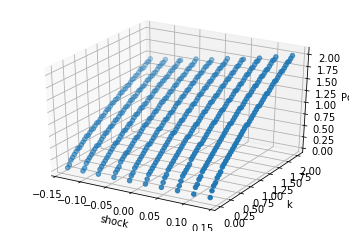

In [23]:
## plot the Value function V(k,ϵ)
x_grid = np.linspace(x[0], x[9], 10)
y_grid = np.linspace(k_low, k_high, nk)

xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx, yyy, pol)
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('Pol');

plt.show()

<Figure size 360x360 with 0 Axes>

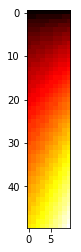

<Figure size 360x360 with 0 Axes>

In [45]:
#print(pol)
fig = plt.figure()
plt.imshow(pol, cmap='hot', interpolation='nearest')
plt.figure(figsize=(5,5))
#plt.show()

In [27]:
@njit
def solve_entrant(params, nk, k_grid, V):
    
    θ, ν, δ, β, ϕ = params
    
    V_0 = np.zeros(10)
    pol_0 = np.zeros_like(V_0)
    
    for ee in range(10):
        max_V = -9999999999999
        idx = 0

        for jj in range(nk):
            kp = k_grid[jj]

            EV = np.dot(V[jj,:],MC[ee,:])
            maxim_val = -kp + β * EV

            if maxim_val > max_V:
                max_V = maxim_val
                idx = jj

        V_0[ee] = max_V
        if max_V >= 0:
            pol_0[ee] = k_grid[int(idx)]
    
    return V_0, pol_0

In [28]:
V_0, pol_0 = solve_entrant(params, nk, k_grid, V)
print(V_0)
print(pol_0)

[1.91532935 1.99886167 2.10326964 2.22165645 2.35405639 2.50195361
 2.66698515 2.85052889 3.04734528 3.23021662]
[0.70040816 0.8222449  0.94408163 1.06591837 1.26897959 1.47204082
 1.71571429 2.         2.         2.        ]


**EXERCISE 4**

In [33]:
@njit
def solve_ex4(nk, k_grid, w, params, c_e, x_stat):
    
    V, pol = solve_incum(w, params, nk, k_grid)
    
    V_0, pol_0 = solve_entrant(params, nk, k_grid, V)
    
    integr = np.dot(x_stat[:],V_0[:])
    
    objective = c_e - integr
    
    return objective

In [36]:
fun = lambda w: solve_ex4(nk, k_grid, w, params, 0.1, x_stat)
w_star = optimize.fsolve(fun, [w_rep])

the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05
the V difference is: 9.899960677373087e-05


In [37]:
print(w_star)

[0.78297156]


**EXERCISE 5**

In [ ]:
def closest_gridpt(grid, point_in):
    pt_index  = np.nanargmin((point_in-grid)**2)
    
    return pt_index

In [ ]:
closept = np.zeros_like(pol)
for ee in range(10):
    for jj in range(nk):
        closept[jj,ee] = closest_gridpt(k_grid, pol[jj,ee])

#print(closept)

In [179]:
@njit
def measure_G(w, params, nk, k_grid, m, NoExit, MC, closept, x_stat):
    eps = 0.0001
    max_iter = 1000
    
    crit = 1
    itr = 0
    
    θ, ν, δ, β, ϕ = params
    
    G = np.ones(nk*10)*0.002 # 1x(nk*10) vector
    
    while crit > eps and itr < max_iter:
        G_new = np.zeros(nk*10)
        Trans_mat = np.zeros((nk*10,nk*10))
        
        for ee in range(10):
            for ee_p in range(10):
                for jj in range(nk):
                    for jj_p in range(nk):
                        indic = 0
                        if closept[jj,ee] == jj_p+1:
                            indic = 1
                        Trans_mat[jj*10+ee,jj_p*10+ee_p] = MC[ee,ee_p] * indic * NoExit[jj,ee]  # (nk*10) x (nk*10) = ... 
        
        #print("Iteration", itr, ": row sum is", np.sum(Trans_mat[1,:]))
        
        G_new = np.dot(G,Trans_mat) # ((1) x (nk*10)) =  ((1) x (nk*10)) * ((nk*10) x (nk*10))      
        #G_new = np.reshape(G_new, (nk,10))
        
        G_fin = np.zeros(nk*10)
        for ff in range(10):
            for kk in range(nk):
                G_fin[kk*10+ff] = G_new[kk*10+ff] + m*x_stat[ff] 
        #G_new = np.reshape(G_new, nk*10)
        
        crit = np.max(np.abs(G - G_fin))
        print("Iteration", itr, ": error is", crit)
        G = G_fin.copy()
        itr += 1
                 
    return G

In [180]:
NoExit = np.where(pol > 0,1,0)
stat_G = measure_G(w_star, params, nk, k_grid, 1, NoExit, MC, closept, x_stat)

Iteration 0 : error is 0.2349956253479843
Iteration 1 : error is 0.4652416508902777
Iteration 2 : error is 0.738531875011179
Iteration 3 : error is 0.8120891270073212
Iteration 4 : error is 1.0242222965427776
Iteration 5 : error is 1.3343696295449652
Iteration 6 : error is 1.5763591361446814
Iteration 7 : error is 1.80406416102974
Iteration 8 : error is 2.0253044974261547
Iteration 9 : error is 2.178015832731326
Iteration 10 : error is 2.276112215986176
Iteration 11 : error is 2.331619360673052
Iteration 12 : error is 2.3624881239365045
Iteration 13 : error is 2.3783243554883917
Iteration 14 : error is 2.386330260746117
Iteration 15 : error is 2.390145963486365
Iteration 16 : error is 2.391732859087007
Iteration 17 : error is 2.3921904051055733
Iteration 18 : error is 2.392116474626505
Iteration 19 : error is 2.3918331746057717
Iteration 20 : error is 2.391486044887955
Iteration 21 : error is 2.3911447964178194
Iteration 22 : error is 2.3908394118084075
Iteration 23 : error is 2.390579

Iteration 226 : error is 2.3895661978282305
Iteration 227 : error is 2.3895661978283442
Iteration 228 : error is 2.3895661978282305
Iteration 229 : error is 2.3895661978282305
Iteration 230 : error is 2.3895661978283442
Iteration 231 : error is 2.3895661978282305
Iteration 232 : error is 2.3895661978282305
Iteration 233 : error is 2.3895661978283442
Iteration 234 : error is 2.389566197828117
Iteration 235 : error is 2.3895661978282305
Iteration 236 : error is 2.389566197828117
Iteration 237 : error is 2.3895661978283442
Iteration 238 : error is 2.3895661978283442
Iteration 239 : error is 2.3895661978283442
Iteration 240 : error is 2.3895661978282305
Iteration 241 : error is 2.3895661978282305
Iteration 242 : error is 2.3895661978283442
Iteration 243 : error is 2.3895661978282305
Iteration 244 : error is 2.3895661978282305
Iteration 245 : error is 2.3895661978283442
Iteration 246 : error is 2.3895661978282305
Iteration 247 : error is 2.389566197828458
Iteration 248 : error is 2.38956619

Iteration 475 : error is 2.3895661978283442
Iteration 476 : error is 2.389566197828117
Iteration 477 : error is 2.389566197828117
Iteration 478 : error is 2.3895661978285716
Iteration 479 : error is 2.389566197828117
Iteration 480 : error is 2.3895661978283442
Iteration 481 : error is 2.3895661978283442
Iteration 482 : error is 2.3895661978283442
Iteration 483 : error is 2.389566197828117
Iteration 484 : error is 2.3895661978283442
Iteration 485 : error is 2.3895661978285716
Iteration 486 : error is 2.389566197828117
Iteration 487 : error is 2.3895661978283442
Iteration 488 : error is 2.3895661978285716
Iteration 489 : error is 2.389566197828117
Iteration 490 : error is 2.3895661978283442
Iteration 491 : error is 2.3895661978283442
Iteration 492 : error is 2.3895661978283442
Iteration 493 : error is 2.389566197828117
Iteration 494 : error is 2.3895661978283442
Iteration 495 : error is 2.3895661978283442
Iteration 496 : error is 2.3895661978283442
Iteration 497 : error is 2.389566197828

Iteration 665 : error is 2.389566197828117
Iteration 666 : error is 2.3895661978283442
Iteration 667 : error is 2.3895661978283442
Iteration 668 : error is 2.3895661978285716
Iteration 669 : error is 2.3895661978283442
Iteration 670 : error is 2.3895661978283442
Iteration 671 : error is 2.3895661978283442
Iteration 672 : error is 2.389566197828117
Iteration 673 : error is 2.3895661978283442
Iteration 674 : error is 2.3895661978285716
Iteration 675 : error is 2.3895661978283442
Iteration 676 : error is 2.3895661978283442
Iteration 677 : error is 2.3895661978283442
Iteration 678 : error is 2.3895661978283442
Iteration 679 : error is 2.3895661978283442
Iteration 680 : error is 2.3895661978283442
Iteration 681 : error is 2.3895661978285716
Iteration 682 : error is 2.389566197828117
Iteration 683 : error is 2.3895661978283442
Iteration 684 : error is 2.3895661978283442
Iteration 685 : error is 2.3895661978285716
Iteration 686 : error is 2.389566197828117
Iteration 687 : error is 2.389566197

Iteration 928 : error is 2.3895661978285716
Iteration 929 : error is 2.389566197828117
Iteration 930 : error is 2.3895661978285716
Iteration 931 : error is 2.389566197828117
Iteration 932 : error is 2.3895661978285716
Iteration 933 : error is 2.3895661978285716
Iteration 934 : error is 2.389566197828117
Iteration 935 : error is 2.389566197828117
Iteration 936 : error is 2.3895661978290264
Iteration 937 : error is 2.389566197828117
Iteration 938 : error is 2.3895661978285716
Iteration 939 : error is 2.389566197828117
Iteration 940 : error is 2.3895661978285716
Iteration 941 : error is 2.389566197828117
Iteration 942 : error is 2.3895661978285716
Iteration 943 : error is 2.3895661978285716
Iteration 944 : error is 2.389566197828117
Iteration 945 : error is 2.3895661978285716
Iteration 946 : error is 2.3895661978285716
Iteration 947 : error is 2.389566197828117
Iteration 948 : error is 2.3895661978290264
Iteration 949 : error is 2.389566197827662
Iteration 950 : error is 2.389566197829026

In [181]:
#print(stat_G)

In [182]:
stat_Gb = np.reshape(stat_G, (nk,10))
#print(stat_Gb)

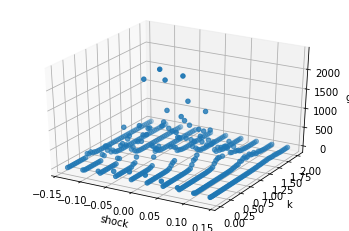

In [184]:
## plot the function g(k,ϵ)
x_grid = np.linspace(x[0], x[9], 10)
y_grid = np.linspace(k_low, k_high, nk)

xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx, yyy, stat_Gb)
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('g');

plt.show()

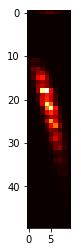

In [185]:
plt.imshow(stat_Gb, cmap='hot', interpolation='nearest')
plt.show()

In [148]:
#print(closept)

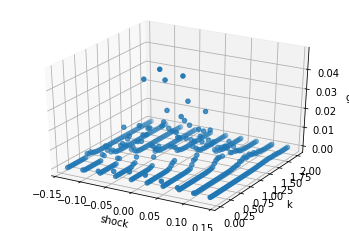

In [187]:
stat_Gc = stat_Gb/np.sum(stat_Gb)
## plot the function g(k,ϵ)
x_grid = np.linspace(x[0], x[9], 10)
y_grid = np.linspace(k_low, k_high, nk)

xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx, yyy, stat_Gc)
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('g');

plt.show()